# Shuffling norm judgments
***
Does the value of a norm have impact on the classification accuracy? We test this hypothesis by applying the `Learn2Split` model and shuffling of the value judgments. In the end, we train the action classification task and compare.

Shuffle strategies:
* Truly randomn
    * Will cause most errornous sentences of the strategies
* Mirroring polarity: Choose the closest opposite value.
* Single polarity: All values are the same
    * This effectively reduces the task to NLI! Here we HAVE to be better!
    
    
### Approach
***
The `L2S` model not only splits a norm, but also conjugates the action:
* `It's wrong to become addicted to gambling.` becomes
    * `It's wrong`
    * `becoming addicted to gambling`

Since the splitting is not reversible as is, there are two possible options to consider:
1. Re-run the original model on concatenated `L2S` output. If the accuracy does not drop, then we can simply do our comparison experiments on `L2S` concat'ed. 
2. Train a `L2S` reverse model (*sigh*)

##### ...and then:
Train the action classification tasks

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from datasets import Dataset

from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import transformers

import torch

from ailignment.datasets.util import get_accuracy_metric
from ailignment.datasets.moral_stories import make_action_classification_dataframe, get_random_value_dataset
import ailignment.datasets.moral_stories_clustered as msc
from ailignment.training import sequence_classification

pd.set_option('display.max_colwidth', 400)
dataframe = pd.read_pickle("../data/moral_stories_proto_l2s.dat")

# a function to convert train and test dataframes to huggingface datasets
def convert_hf_dataset(tokenizer, train, test, padding="max_length"):
    def tok(samples):
        return tokenizer(samples["action"], samples["norm"], padding=padding, 
                         truncation=True, return_token_type_ids=True)

    train_data = Dataset.from_pandas(train)
    train_data = train_data.map(tok, batched=True)
    val_data = Dataset.from_pandas(test)
    val_data = val_data.map(tok, batched=True)
    return train_data, val_data

### Action classification on `L2S` concatenated
***
Question: If we concatenate the norm judgment with the conjugated norm action, does the accuracy change?

The task was run for 5 epochs on the `roberta-large` model:
* Epoch 5: 0.913 accuracy

Although not a thorough analysis in any capacity, we argue that the performance is not significantly reduced by the simplistic concatenation approach. The upcoming experiments on the shuffled datasets can be carried out without greater worries!

In [2]:
data = dataframe.copy()
data["norm"] = data["norm_value"] + " " + data["norm_action"]
train, test = make_action_classification_dataframe(data, test_size=0.1)

In [3]:
name = "bert-large-uncased"
#name = "ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name)

train_data, val_data = convert_hf_dataset(tokenizer, train, test)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [4]:
training_args = TrainingArguments(
    output_dir="/data/kiehne/results/shuffled_values/random/bert-large-uncased/0.50/",
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='logs/',
    log_level="info",
    logging_steps=500,
    evaluation_strategy="epoch",
    save_steps=30000000,
    save_strategy="epoch",
    learning_rate=1e-6
)
acc_metric = get_accuracy_metric()

In [5]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=acc_metric,
)
logs = trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: intention, l2s_output, norm_action, ID, norm, norm_storyfied, situation, __index_level_0__, consequence, norm_value, norm_sentiment, action, actor_name.
***** Running training *****
  Num examples = 21592
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 13495
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/transformers/models/bert/modeling_bert.py", line 1524, in forward
    outputs = self.bert(
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/transformers/models/bert/modeling_bert.py", line 990, in forward
    encoder_outputs = self.encoder(
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/transformers/models/bert/modeling_bert.py", line 582, in forward
    layer_outputs = layer_module(
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/transformers/models/bert/modeling_bert.py", line 470, in forward
    self_attention_outputs = self.attention(
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/transformers/models/bert/modeling_bert.py", line 401, in forward
    self_outputs = self.self(
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/transformers/models/bert/modeling_bert.py", line 333, in forward
    attention_probs = self.dropout(attention_probs)
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/modules/dropout.py", line 58, in forward
    return F.dropout(input, self.p, self.training, self.inplace)
  File "/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/functional.py", line 1169, in dropout
    return _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 10.76 GiB total capacity; 5.54 GiB already allocated; 9.31 MiB free; 5.60 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


# Experiments: Single model training
***
Pick a dataset, then run the finetuning. Useful for explorative analysis

In [3]:
# without clustering
data = get_random_value_dataset(dataframe, p=0.5, top_n=20)
train, test = make_action_classification_dataframe(data, test_size=0.1)

In [ ]:
# with clustering
dataframe = msc.assign_norm_clusters(dataframe)
data = msc.get_random_value_dataset(dataframe, 0.5, top_n=20)
train, test = msc.make_action_classification_dataframe(data, test_size=0.1)

In [4]:
name = "roberta-large"
name = "bert-base-uncased"
name = "/data/kiehne/results/shuffled_values/random/bert-base-uncased/0.00/checkpoint-5625/"
#name = "ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli"
name = "bert-large-uncased"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name)

train_data, val_data = convert_hf_dataset(tokenizer, train, test)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [5]:
training_args = TrainingArguments(
    output_dir="/data/kiehne/results/shuffled_values/random/bert-large-uncased/0.50/",
    num_train_epochs=7,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    warmup_steps=500,
    #weight_decay=0.01,
    logging_dir='logs/',
    log_level="info",
    logging_steps=500,
    evaluation_strategy="epoch",
    save_steps=30000000,
    save_strategy="epoch",
    learning_rate=1e-6
)
acc_metric = get_accuracy_metric()

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=acc_metric,
)
logs = trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: situation, intention, l2s_output, norm_storyfied, flipped, action, norm_sentiment, norm_action, __index_level_0__, ID, norm, consequence, actor_name, norm_value.
***** Running training *****
  Num examples = 21592
  Num Epochs = 7
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 18893
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.706600,0.692114,0.510000
2,0.694700,0.682954,0.567083


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: situation, intention, l2s_output, norm_storyfied, flipped, action, norm_sentiment, norm_action, __index_level_0__, ID, norm, consequence, actor_name, norm_value.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/bert-large-uncased/0.50/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random/bert-large-uncased/0.50/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/bert-large-uncased/0.50/checkpoint-2699/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was aske

# Experiments: Consecutive models
***
Run several models over different training data or with different hyperparameters.

### Random values experiment
***
Given different values of $p$, how is the accuracy affected? 

First run:
* Single epoch, batch size 8, $p\in\{0,0.1,0.2,..,1\}$

In [4]:
transformers.logging.set_verbosity_warning()

ps = np.linspace(0,1,11)
test_size = 0.1
model = "roberta-base"
#model = "roberta-large"

#model = "bert-base-uncased"
#model = "/data/kiehne/results/shuffled_values/random/bert-base-uncased/1.00/checkpoint-5625/"
model = "bert-large-uncased"

#model = "albert-xxlarge-v2"
#model = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model)

dataframe = pd.read_pickle("../data/moral_stories_proto_l2s.dat")
#dataframe = msc.assign_norm_clusters(dataframe)

acc_metric = get_accuracy_metric()
results = []

for p in ps:
    # create dataset
    #random_values = msc.get_random_value_dataset(dataframe, p, top_n=20)
    #train, test = msc.make_action_classification_dataframe(random_values, test_size=test_size)
    data = get_random_value_dataset(dataframe, p=p, top_n=20)
    train, test = make_action_classification_dataframe(data, test_size=test_size)
    
    # create training args
    out_dir = f"/data/kiehne/results/shuffled_values/random_no_pretrain/{model}/{p:0.2f}/"
    #out_dir = f"/data/kiehne/results/shuffled_values/random_ms_only_pretrain/bert-base-uncased/{p:0.2f}/"

    training_args = TrainingArguments(
        output_dir=out_dir,
        num_train_epochs=5,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=500,
        #weight_decay=0.01,
        logging_steps=500,
        evaluation_strategy="epoch",
        save_steps=30000000,
        save_strategy="epoch",
        learning_rate=1e-6
    )
    
    # create data loading function
    data_loader = lambda tokenizer: convert_hf_dataset(tokenizer, train, test)
    if "gpt2" in model:
        data_loader = lambda tokenizer: convert_hf_dataset(tokenizer, train, test, padding="do_not_pad")

    
    r = sequence_classification(data_loader, model, training_args, tokenizer, 
                                acc_metric, use_pretrained=False)
    results.append(r)
    
    # save training data for later evaluation
    train.to_pickle(out_dir+"train.dat")
    test.to_pickle(out_dir+"test.dat")

accuracies = [[y["eval_accuracy"] for y in x if "eval_accuracy" in y] for x in results]

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 13495
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.688500,0.669063,0.582083
2,0.666900,0.646622,0.628750
3,0.637400,0.629407,0.642917
4,0.615500,0.631621,0.655833
5,0.621500,0.625205,0.659583


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.00/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.00/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.00/checkpoint-2699/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 13495
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.702000,0.692056,0.507500
2,0.681900,0.666379,0.592083
3,0.671000,0.686432,0.570417
4,0.652700,0.659723,0.602917
5,0.644000,0.661151,0.607083


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.10/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.10/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.10/checkpoint-2699/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 13495
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.705600,0.694622,0.500000
2,0.698400,0.688698,0.531250
3,0.682400,0.686607,0.556250
4,0.677300,0.679257,0.581250
5,0.681200,0.677327,0.584583


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.20/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.20/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.20/checkpoint-2699/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 13495
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.697100,0.696442,0.500000
2,0.704200,0.692649,0.510833
3,0.696500,0.691308,0.532083
4,0.694100,0.694949,0.525833
5,0.690300,0.688906,0.546250


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.30/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.30/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.30/checkpoint-2699/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 13495
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.703000,0.698759,0.500000
2,0.700500,0.693756,0.500000
3,0.700100,0.694509,0.500000
4,0.697800,0.693385,0.500000
5,0.697200,0.693094,0.500000


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.40/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.40/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.40/checkpoint-2699/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 13495
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.704500,0.698303,0.500000
2,0.700600,0.694564,0.500000
3,0.697200,0.697316,0.500000
4,0.699800,0.693213,0.500000
5,0.699000,0.693200,0.500000


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.50/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.50/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.50/checkpoint-2699/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 13495
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.704100,0.694529,0.500000
2,0.703000,0.695217,0.500000
3,0.697100,0.694257,0.500000
4,0.698600,0.695150,0.500000
5,0.697000,0.693065,0.500417


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.60/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.60/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.60/checkpoint-2699/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 13495
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.703400,0.695937,0.500000
2,0.700900,0.695114,0.500000
3,0.696600,0.692331,0.520833
4,0.696800,0.691864,0.528750
5,0.691700,0.690360,0.522917


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.70/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.70/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.70/checkpoint-2699/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 13495
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.698600,0.692000,0.540833
2,0.697500,0.686575,0.547917
3,0.684400,0.688150,0.562500
4,0.680400,0.683564,0.565417
5,0.673500,0.684133,0.571250


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.80/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.80/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.80/checkpoint-2699/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 13495
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.699600,0.728070,0.500000
2,0.686200,0.669119,0.593750
3,0.661500,0.665300,0.603750
4,0.658900,0.669084,0.610000
5,0.648900,0.659022,0.624583


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.90/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.90/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/0.90/checkpoint-2699/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 13495
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.695000,0.688663,0.559583
2,0.657100,0.636879,0.640833
3,0.638300,0.653263,0.643750
4,0.624900,0.623647,0.652917
5,0.614800,0.625198,0.656667


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: norm, ID, norm_sentiment, flipped, norm_action, actor_name, norm_storyfied, norm_value, intention, consequence, __index_level_0__, l2s_output, situation, action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/1.00/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/1.00/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random_no_pretrain/bert-large-uncased/1.00/checkpoint-2699/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

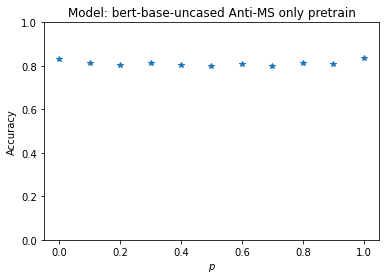

In [3]:
# topn=20
import matplotlib.pyplot as plt
# this is the random init bert
max_acc = [max(a) for a in accuracies]
plt.plot(ps, max_acc, "*")
plt.ylim(0,1)
plt.title(f"Model: bert-base-uncased Anti-MS only pretrain")
plt.xlabel("$p$")
plt.ylabel("Accuracy")
plt.show()

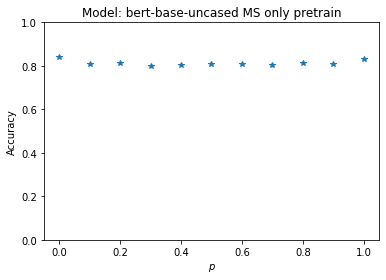

In [4]:
# topn=20
import matplotlib.pyplot as plt
# this is the random init bert
max_acc = [max(a) for a in accuracies]
plt.plot(ps, max_acc, "*")
plt.ylim(0,1)
plt.title(f"Model: bert-base-uncased MS only pretrain")
plt.xlabel("$p$")
plt.ylabel("Accuracy")
plt.show()

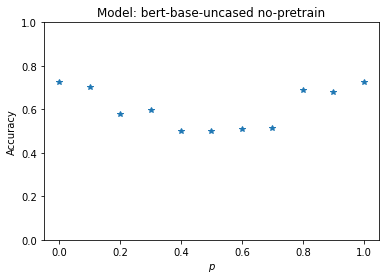

In [4]:
# topn=20
import matplotlib.pyplot as plt
# this is the random init bert
max_acc = [max(a) for a in accuracies]
plt.plot(ps, max_acc, "*")
plt.ylim(0,1)
plt.title(f"Model: {model} no-pretrain")
plt.xlabel("$p$")
plt.ylabel("Accuracy")
plt.show()

# Experiments: Moral Stories only pretraining
***
If we pretrain an LM on the original Moral Stories dataset, is it able to achieve constant performance?

Todo:
* Take a pretrained BERT for the original MS task
* Finetune it to the other versions of the CMS dataset

# Post training evaluation
***
Whenever your local machine loses connection to a running notebook it will not receive the console outputs anymore, even though it might be connected to the kernel.
This is a known issue in jupyter, which will not be addressed anytime soon.

In [ ]:
import os
from ailignment.training.finetune import clean_up_mem

@clean_up_mem
def evaluate(path):
    '''
    Loads the model in `path` and runs test evaluation on it
    '''
    model = AutoModelForSequenceClassification.from_pretrained(path)
    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=acc_metric,
    )
    logs = trainer.evaluate(val_data)
    return logs

def evaluate_folder(folder):
    '''
    Runs `evaluate` on all checkpoints in the given folder.
    Returns a dict {"checkpoint-X": log_dict, .. }
    '''
    ckpts = os.listdir(folder)
    results = {ckpt:evaluate(os.path.join(folder, ckpt)) for ckpt in ckpts}
    return results

In [ ]:
import os

transformers.logging.set_verbosity_warning()

ps = np.linspace(0,1,11)
test_size = 0.1
seed = 3
model = "roberta-base"
model = "bert-base-uncased"

acc_metric = get_accuracy_metric()
results = []

dataframe = pd.read_pickle("../data/moral_stories_proto_l2s.dat")


paths = [f"/data/kiehne/results/shuffled_values/random/{model}/{p:.2f}/checkpoint-5625" for p in ps]
for p, path in zip(ps,paths):
    random_values = dataframe.apply(simplify_norm_value, axis=1).apply(flip_norm(p), axis=1)
    train, test = make_action_classification_dataframe(random_values)

    # create training args
    training_args = TrainingArguments(
        output_dir=f"/data/kiehne/results/shuffled_values/random/{model}/{p:0.2f}/",
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=1,
        warmup_steps=500,
        #weight_decay=0.01,
        logging_dir='logs/',
        log_level="info",
        logging_steps=500,
        evaluation_strategy="epoch",
        save_steps=30000000,
        save_strategy="epoch",
        learning_rate=1e-5
    )
    
    # create data loading function
    def data_func(tokenizer):
        def tok(samples):
            return tokenizer(samples["action"], samples["norm"], padding="max_length", 
                             truncation=True, return_token_type_ids=True)

        train_data = Dataset.from_pandas(train)
        train_data = train_data.map(tok, batched=True)
        val_data = Dataset.from_pandas(test)
        val_data = val_data.map(tok, batched=True)
        return train_data, val_data
    print(ps, path)